# (Re-) Exploring HDB Resale Flat Data in 17 Graphs
About a year ago, I published [my first post on data&stuff](https://dataandstuff.wordpress.com/2017/08/14/hdb-resale-flat-prices-in-singapore/). I applied econometric techniques to develop three least squares regression models to explain HDB resale flat prices. A year on, I'm re-visiting the expanded dataset (now includes an additional year of data) with new skills and knowledge. This time, I intend to apply proper data science techniques to accurately predict prices.  
  
In this first post, I perform exploratory data analysis (EDA) on the dataset. In subsequent posts, I will develop a more complex regression model to predict resale flat prices.

In [1]:
# Import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Settings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Modify settings
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'
mpl.rcParams['grid.color'] = '#e8e8e8'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['xtick.color'] = '#494949'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.color'] = '#494949'
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.edgecolor'] = '#494949'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.labelpad'] = 15
mpl.rcParams['axes.labelcolor'] = '#494949'
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Raleway'
mpl.rcParams['scatter.marker'] = 'h'

# Colours
def get_cols():
    
    print('[Colours]:')
    print('Orange:     #ff9966')
    print('Navy Blue:  #133056')
    print('Light Blue: #b1ceeb')
    print('Green:      #6fceb0')
    print('Red:        #f85b74')

    return

In [3]:
# Read data
hdb = pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2015-onwards.csv')

## Target: Resale Prices
As we can see, resale prices are right-skewed (mean is to the right of the median). The mean resale price transacted was a whopping $440,000. Singaporeans must be crazy rich to afford a resale flat in this era.

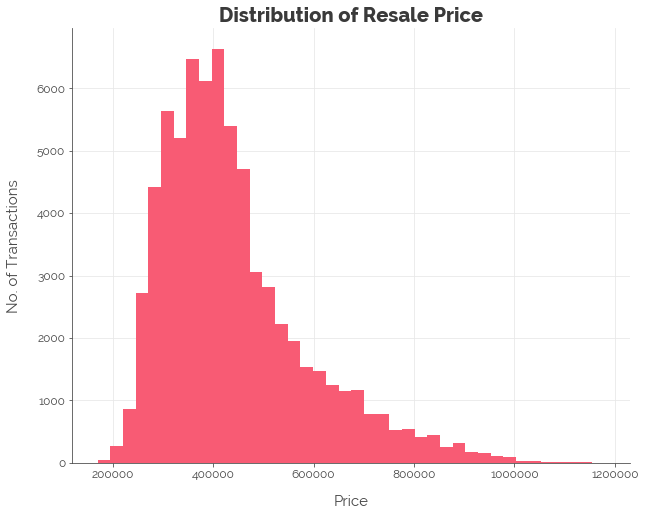

In [4]:
# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.title.set_color('#3a3a3a')
hdb.resale_price.plot.hist(color = '#f85b74', bins = 40)
plt.title('Distribution of Resale Price', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.xlabel('Price')
plt.ylabel('No. of Transactions')
plt.show()

## Date and Month Purchased
First, note that the `month` feature combines both the month and the year. Let's split these up while preserving the original notation.

In [5]:
# Rename month variable
hdb = hdb.rename(columns={'month': 'year_mth'})

# Add variables for month and year
hdb['year'] = pd.to_numeric(hdb.year_mth.str[:4])
hdb['month'] = pd.to_numeric(hdb.year_mth.str[5:])

From the graph below, we find that there are "hot" and "cold" periods for buying resale flats, with a surge in recent months. We note how lots of transactions take place on a regular basis: at least 1,000 per month. At the median price, that's approximately $4.4 billion transacted per month.

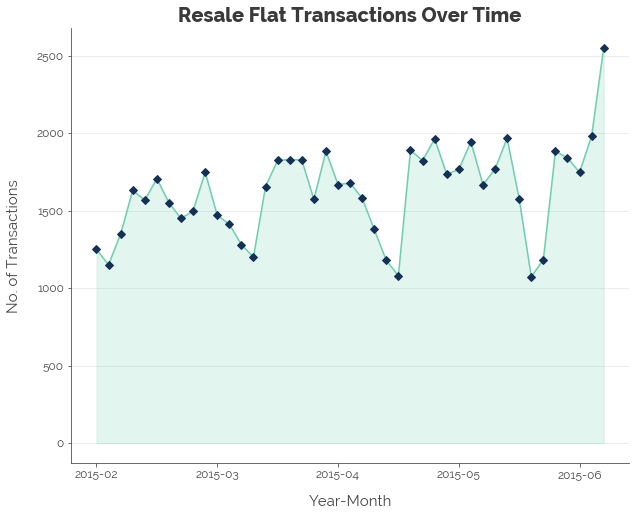

In [6]:
# Summarise data
price_year = hdb.groupby('year_mth').resale_price.count()
xlabs = list(price_year.index)

# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.set_xticklabels(price_year.index)
ax.title.set_color('#3a3a3a')
plt.plot(price_year.values, color = '#6fceb0')
plt.plot(price_year.values, 'D', color = '#133056')
plt.fill_between(np.arange(0, len(price_year), 1), price_year.values, color = '#6fceb0', alpha = 0.2)
plt.title('Resale Flat Transactions Over Time', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.ylabel('No. of Transactions')
plt.xlabel('Year-Month')
plt.show()

### Relation with Target
Plotting the median resale price from 2015 onwards, we find that the median price has remained stable over time. In addition, the variation in prices has remained relatively wide. Hence, as in my [first post](https://dataandstuff.wordpress.com/2017/08/14/hdb-resale-flat-prices-in-singapore/) on HDB resale flat prices, we will assume that the relationship between the flat characteristics and resale flat prices is stable for all transactions in the dataset. In other words, we treat the transactions as having occurred within a single, stable time period.

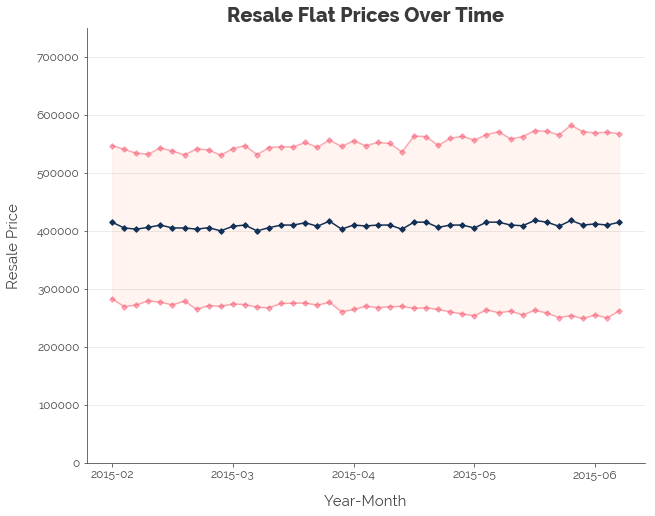

In [7]:
# Summarise data
medprice_year = hdb.groupby('year_mth').resale_price.median()
xlabs = list(medprice_year.index)

sdprice_year = hdb.groupby('year_mth').resale_price.std()

# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.set_xticklabels(medprice_year.index)
ax.title.set_color('#3a3a3a')
plt.plot(medprice_year.values + sdprice_year.values, color = '#f85b74', alpha = 0.5)
plt.plot(medprice_year.values + sdprice_year.values, "D", color = '#f85b74', alpha = 0.5, markersize = 4)
plt.plot(medprice_year.values - sdprice_year.values, color = '#f85b74', alpha = 0.5)
plt.plot(medprice_year.values - sdprice_year.values, "D", color = '#f85b74', alpha = 0.5, markersize = 4)
plt.fill_between(np.arange(0, len(medprice_year), 1),
                 medprice_year.values - sdprice_year.values,
                 medprice_year.values + sdprice_year.values,
                 color = '#ff9966', alpha = 0.1)
plt.plot(medprice_year.values, color = '#133056')
plt.plot(medprice_year.values, 'D', color = '#133056', markersize = 4)
plt.title('Resale Flat Prices Over Time', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.ylabel('Resale Price')
plt.xlabel('Year-Month')
plt.ylim((0, 750000))
plt.show()

# Town

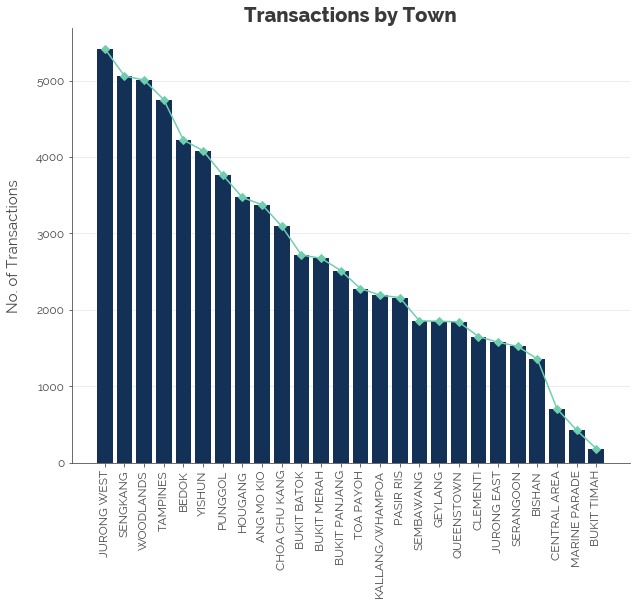

In [8]:
# Extract data
town_count = hdb.town.value_counts()

# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.title.set_color('#3a3a3a')
plt.bar(np.arange(0, len(town_count), 1), list(town_count.values), color = '#133056')
plt.plot(np.arange(0, len(town_count), 1), list(town_count.values), color = '#6fceb0', marker = 'D')
ax.set_xticklabels(town_count.index, rotation = 'vertical')
ax.set_xticks(np.arange(0, len(town_count), 1), minor = False)
plt.title('Transactions by Town', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.ylabel('No. of Transactions')
plt.show()

### Relation with Target
We find high variability in resale flat prices across the respective towns. This tells us that towns are an important factor in predicting resale flat prices.

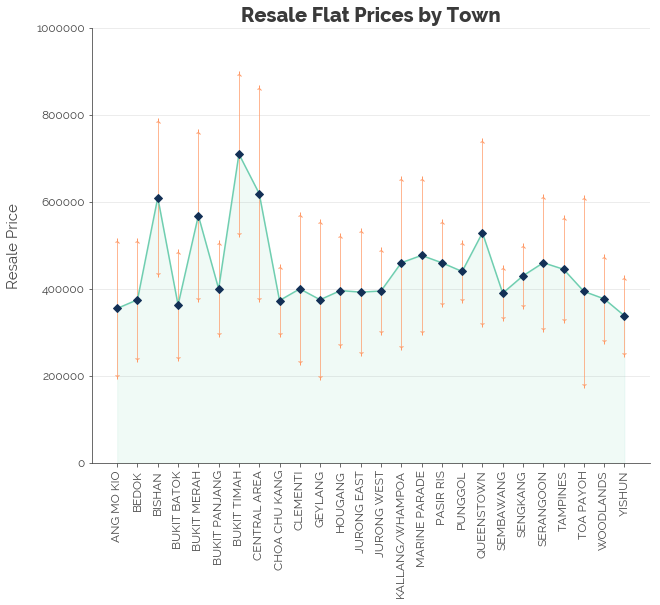

In [9]:
# Summarise data
medprice_town = hdb.groupby('town').resale_price.median()
xlabs = list(medprice_town.index)
sdprice_town = hdb.groupby('town').resale_price.std()

# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.set_xticklabels(medprice_town.index)
ax.title.set_color('#3a3a3a')
plt.plot(medprice_town.values, color = '#6fceb0')
plt.fill_between(np.arange(0, len(medprice_town), 1), medprice_town.values, color = '#6fceb0', alpha = 0.1)
plt.plot(medprice_town.values, 'D', color = '#133056')
plt.plot(medprice_town.values + sdprice_town.values, '2', color = '#ff9966')
plt.plot(medprice_town.values - sdprice_town.values, '1', color = '#ff9966')
plt.vlines(np.arange(0, len(medprice_town), 1),
           medprice_town.values - sdprice_town.values,
           medprice_town.values + sdprice_town.values,
           color = '#ff9966', linewidth = 1, alpha = 0.7)
ax.set_xticklabels(medprice_town.index, rotation = 'vertical')
ax.set_xticks(np.arange(0, len(medprice_town), 1), minor = False)
plt.title('Resale Flat Prices by Town', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.ylabel('Resale Price')
plt.ylim((0, 1000000))
plt.show()

## Flat Type

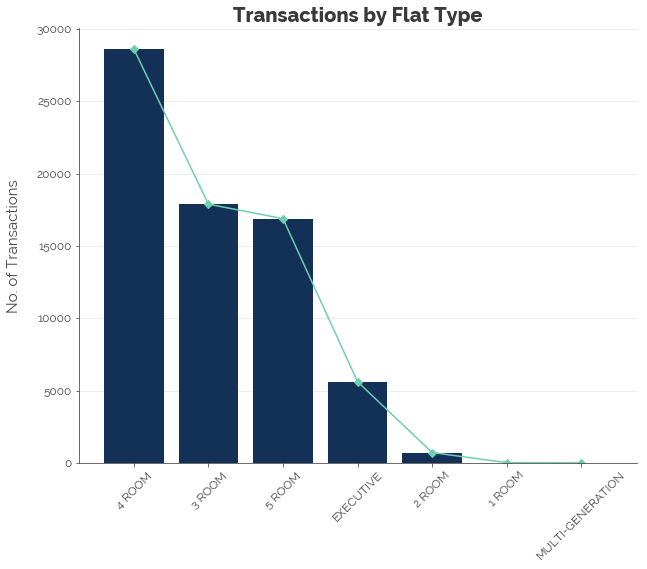

In [10]:
# Extract data
type_count = hdb.flat_type.value_counts()

# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.title.set_color('#3a3a3a')
plt.bar(np.arange(0, len(type_count), 1), list(type_count.values), color = '#133056')
plt.plot(np.arange(0, len(type_count), 1), list(type_count.values), color = '#6fceb0', marker = 'D')
ax.set_xticklabels(type_count.index, rotation = '45')
ax.set_xticks(np.arange(0, len(type_count), 1), minor = False)
plt.title('Transactions by Flat Type', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.ylabel('No. of Transactions')
plt.show()

### Relation to Target
Naturally, we would expect flats that are "high SES" to have a higher resale price:

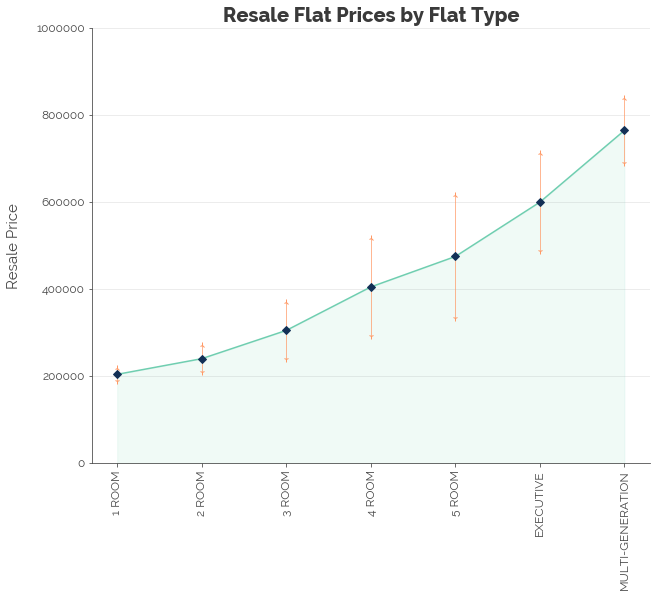

In [11]:
# Summarise data
medprice_type = hdb.groupby('flat_type').resale_price.median()
xlabs = list(medprice_type.index)
sdprice_type = hdb.groupby('flat_type').resale_price.std()

# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.set_xticklabels(medprice_type.index)
ax.title.set_color('#3a3a3a')
plt.plot(medprice_type.values, color = '#6fceb0')
plt.fill_between(np.arange(0, len(medprice_type), 1), medprice_type.values, color = '#6fceb0', alpha = 0.1)
plt.plot(medprice_type.values, 'D', color = '#133056')
plt.plot(medprice_type.values + sdprice_type.values, '2', color = '#ff9966')
plt.plot(medprice_type.values - sdprice_type.values, '1', color = '#ff9966')
plt.vlines(np.arange(0, len(medprice_type), 1),
           medprice_type.values - sdprice_type.values,
           medprice_type.values + sdprice_type.values,
           color = '#ff9966', linewidth = 1, alpha = 0.7)
ax.set_xticklabels(medprice_type.index, rotation = 'vertical')
ax.set_xticks(np.arange(0, len(medprice_type), 1), minor = False)
plt.title('Resale Flat Prices by Flat Type', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.ylabel('Resale Price')
plt.ylim((0, 1000000))
plt.show()

## Storey Range

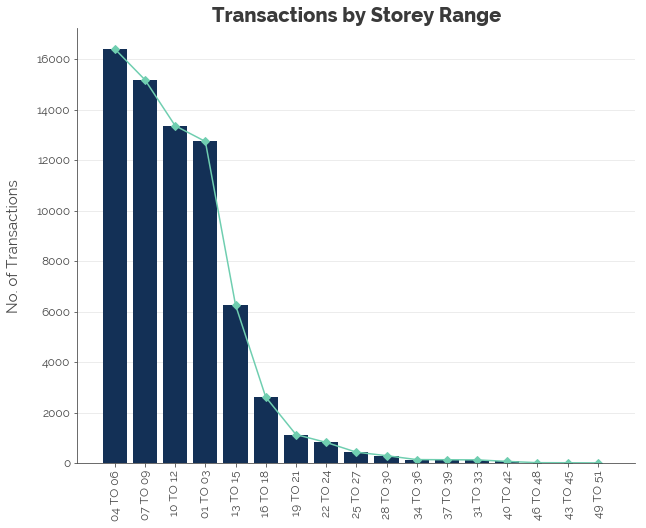

In [12]:
# Extract data
storey_count = hdb.storey_range.value_counts()

# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.title.set_color('#3a3a3a')
plt.bar(np.arange(0, len(storey_count), 1), list(storey_count.values), color = '#133056')
plt.plot(np.arange(0, len(storey_count), 1), list(storey_count.values), color = '#6fceb0', marker = 'D')
ax.set_xticklabels(storey_count.index, rotation = 'vertical')
ax.set_xticks(np.arange(0, len(storey_count), 1), minor = False)
plt.title('Transactions by Storey Range', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.ylabel('No. of Transactions')
plt.show()

### Relation to Target
Conventional wisdom would tell us that the higher the storey, the nicer the view. The nicer the view, the higher the resale price. The data appears to agree.

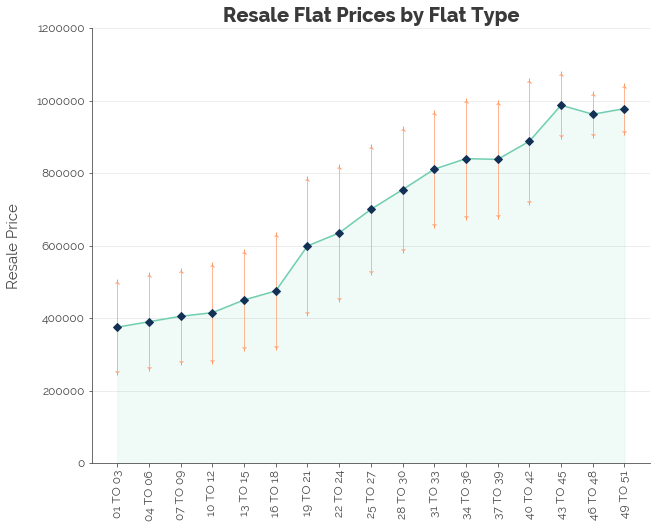

In [13]:
# Summarise data
medprice_storey = hdb.groupby('storey_range').resale_price.median()
xlabs = list(medprice_type.index)
sdprice_storey = hdb.groupby('storey_range').resale_price.std()

# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.set_xticklabels(medprice_storey.index)
ax.title.set_color('#3a3a3a')
plt.plot(medprice_storey.values, color = '#6fceb0')
plt.fill_between(np.arange(0, len(medprice_storey), 1), medprice_storey.values, color = '#6fceb0', alpha = 0.1)
plt.plot(medprice_storey.values, 'D', color = '#133056')
plt.plot(medprice_storey.values + sdprice_storey.values, '2', color = '#ff9966')
plt.plot(medprice_storey.values - sdprice_storey.values, '1', color = '#ff9966')
plt.vlines(np.arange(0, len(medprice_storey), 1),
           medprice_storey.values - sdprice_storey.values,
           medprice_storey.values + sdprice_storey.values,
           color = '#ff9966', linewidth = 1, alpha = 0.7)
ax.set_xticklabels(medprice_storey.index, rotation = 'vertical')
ax.set_xticks(np.arange(0, len(medprice_storey), 1), minor = False)
plt.title('Resale Flat Prices by Flat Type', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.ylabel('Resale Price')
plt.ylim((0, 1200000))
plt.show()

## Floor Area

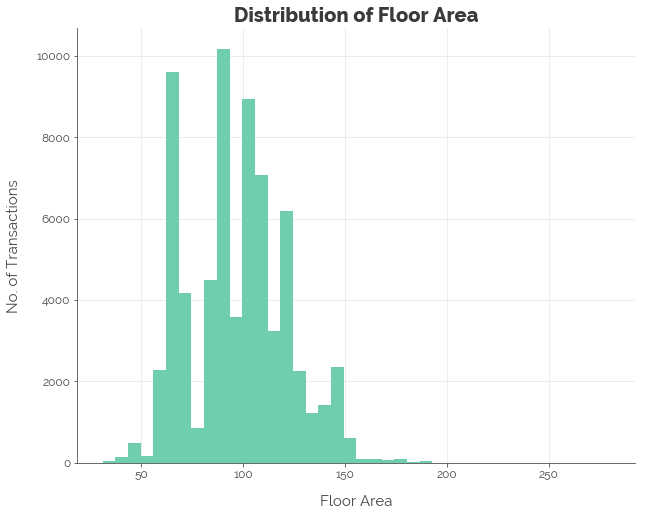

In [14]:
# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.title.set_color('#3a3a3a')
hdb.floor_area_sqm.plot.hist(color = '#6fceb0', bins = 40)
plt.title('Distribution of Floor Area', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.xlabel('Floor Area')
plt.ylabel('No. of Transactions')
plt.show()

### Relation to Target
Conventional wisdom would also suggest a positive relationship between floor area and price. Yet again, the data appears to agree.

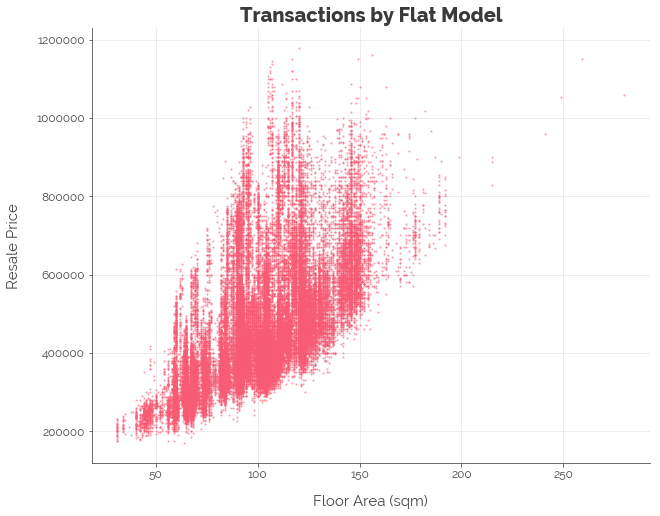

In [15]:
# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.title.set_color('#3a3a3a')
ax.grid(b=True)
plt.scatter(hdb.floor_area_sqm, hdb.resale_price, color = '#f85b74', alpha = 0.4, s = 2)
plt.title('Transactions by Flat Model', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.ylabel('Resale Price')
plt.xlabel('Floor Area (sqm)')
plt.show()

## Flat Model

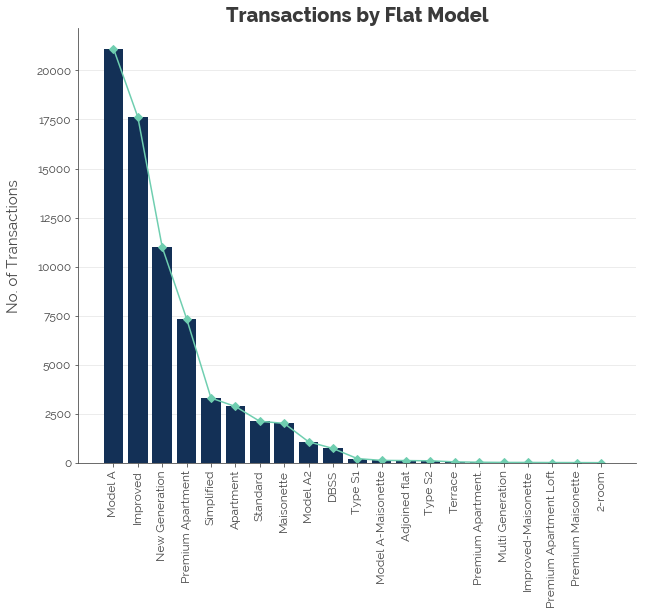

In [16]:
# Extract data
model_count = hdb.flat_model.value_counts()

# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.title.set_color('#3a3a3a')
plt.bar(np.arange(0, len(model_count), 1), list(model_count.values), color = '#133056')
plt.plot(np.arange(0, len(model_count), 1), list(model_count.values), color = '#6fceb0', marker = 'D')
ax.set_xticklabels(model_count.index, rotation = 'vertical')
ax.set_xticks(np.arange(0, len(model_count), 1), minor = False)
plt.title('Transactions by Flat Model', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.ylabel('No. of Transactions')
plt.show()

### Relation to Target
There appears to be high variability in resale prices across flat types. This suggests that flat types will be useful for prediction.

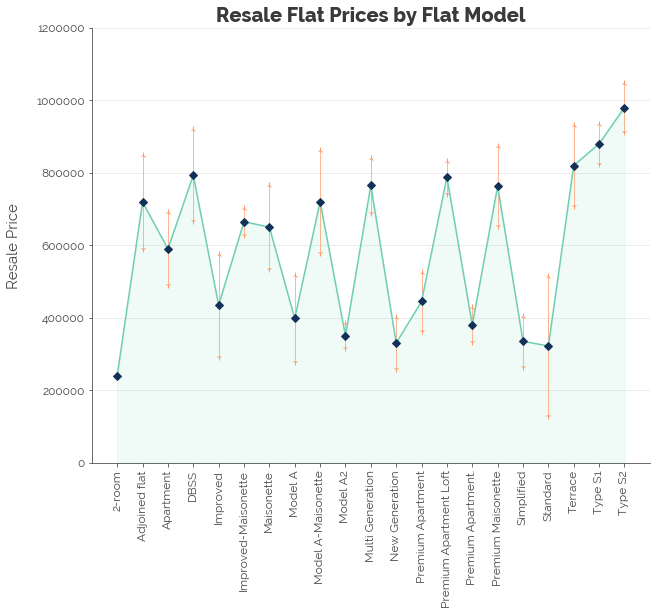

In [17]:
# Summarise data
medprice_model = hdb.groupby('flat_model').resale_price.median()
xlabs = list(medprice_type.index)
sdprice_model = hdb.groupby('flat_model').resale_price.std()

# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.set_xticklabels(medprice_model.index)
ax.title.set_color('#3a3a3a')
plt.plot(medprice_model.values, color = '#6fceb0')
plt.fill_between(np.arange(0, len(medprice_model), 1), medprice_model.values, color = '#6fceb0', alpha = 0.1)
plt.plot(medprice_model.values, 'D', color = '#133056')
plt.plot(medprice_model.values + sdprice_model.values, '2', color = '#ff9966')
plt.plot(medprice_model.values - sdprice_model.values, '1', color = '#ff9966')
plt.vlines(np.arange(0, len(medprice_model), 1),
           medprice_model.values - sdprice_model.values,
           medprice_model.values + sdprice_model.values,
           color = '#ff9966', linewidth = 1, alpha = 0.7)
ax.set_xticklabels(medprice_model.index, rotation = 'vertical')
ax.set_xticks(np.arange(0, len(medprice_model), 1), minor = False)
plt.title('Resale Flat Prices by Flat Model', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.ylabel('Resale Price')
plt.ylim((0, 1200000))
plt.show()

## Lease Commencement Date
Although we expect a higher price for later lease commencement dates, the relationship is not all that clear. Perhaps remaining lease is a bigger factor.

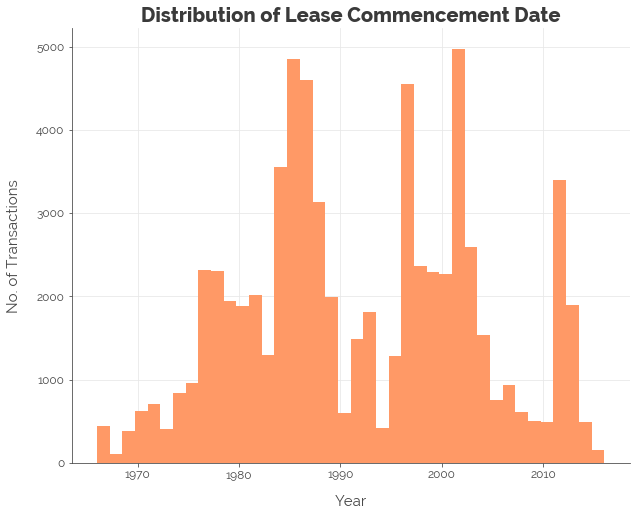

In [18]:
# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.title.set_color('#3a3a3a')
hdb.lease_commence_date.plot.hist(color = '#ff9966', bins = 40)
plt.title('Distribution of Lease Commencement Date', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.xlabel('Year')
plt.ylabel('No. of Transactions')
plt.show()

### Relation to Target

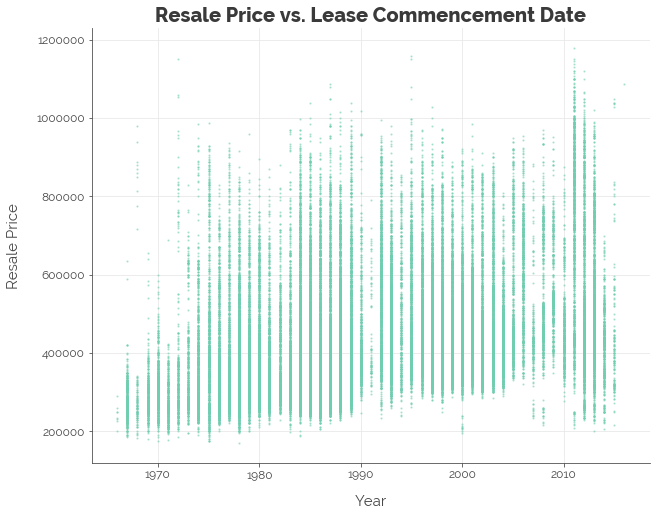

In [19]:
# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.title.set_color('#3a3a3a')
ax.grid(b=True)
plt.scatter(hdb.lease_commence_date, hdb.resale_price, color = '#6fceb0', alpha = 0.4, s = 2)
plt.title('Resale Price vs. Lease Commencement Date', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.ylabel('Resale Price')
plt.xlabel('Year')
plt.show()

## Remaining Lease

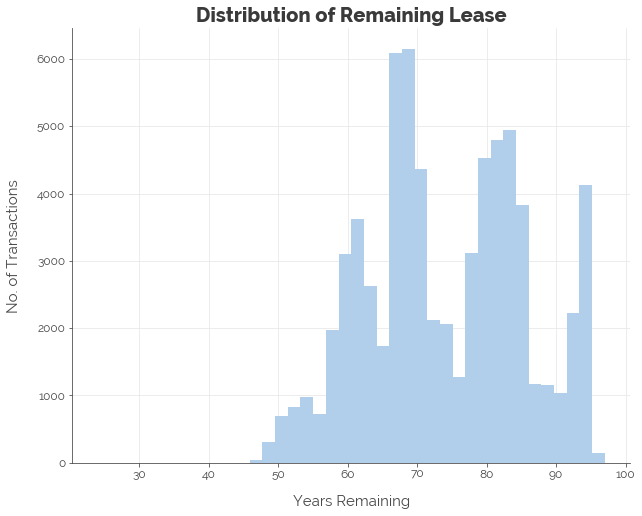

In [20]:
# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.title.set_color('#3a3a3a')
hdb.remaining_lease.plot.hist(color = '#b1ceeb', bins = 40)
plt.title('Distribution of Remaining Lease', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.xlabel('Years Remaining')
plt.ylabel('No. of Transactions')
plt.show()

### Relation to Target
We find a positive relationship between resale price and the remaining years in lease from 50 to 90 years. However, from 90 years onwards (referring to Build-to-Order (BTO) flats sold in the last 5 years), the relationship weakens substantially, and the variation increases substantially as well. This suggests that we could create a special category for transactions of flats with 95 years remaining in their leases to predict resale prices.

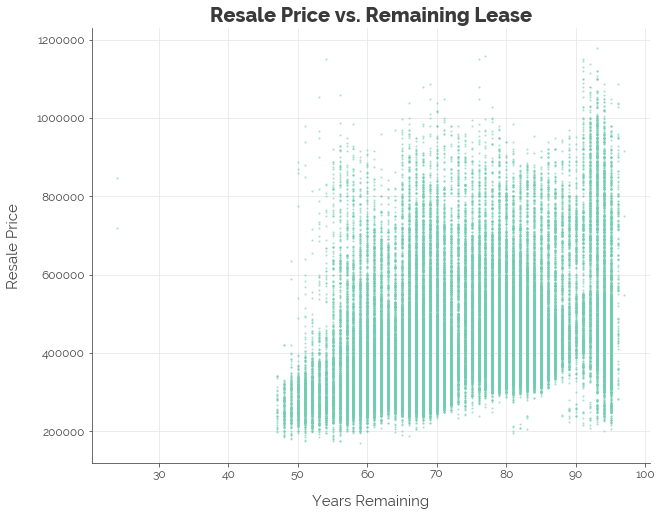

In [21]:
# Plot
plt.figure(figsize = (10,8))
ax = plt.gca()
ax.title.set_color('#3a3a3a')
ax.grid(b=True)
plt.scatter(hdb.remaining_lease, hdb.resale_price, color = '#6fceb0', alpha = 0.4, s = 2)
plt.title('Resale Price vs. Remaining Lease', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.ylabel('Resale Price')
plt.xlabel('Years Remaining')
plt.show()